In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow
!pip install tflite_support
!pip install flatbuffers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 26.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 45.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into ac

In [41]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix


from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [4]:
IMAGES_PATH = "../input/citypersondata/leftImg8bit_trainvaltest/leftImg8bit"
ANNOTS_PATH = "../input/citypersondata/gtBboxCityPersonsWithDangerLevel/gtBboxCityPersonsWithDangerLevel"
BASE_OUTPUT = "output"

TRAIN_FILENAMES = "../input/citypersondata-annot/train.txt"
TEST_FILENAMES = "../input/citypersondata-annot/test.txt"
VAL_FILENAMES = "../input/citypersondata-annot/val.txt"

NUM_CLASSES = 3
OUTPUT_CLASSES = 4 #classes + background

INIT_LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 4
BUFFER_SIZE = 40

IMG_H = 512#224#512 #384 #360
IMG_W = 512 #224 #512 #512 #480

In [5]:
def getClassFromJson(json_path):
    json_f = open(json_path)
    data = json.load(json_f)
    objects = data["objects"]
    highest_num = 0
    for o in objects:
        danger_level = None
        if "danger_level" in o:
            danger_level = int(o["danger_level"])
        else:
            danger_level = int(o["my_label"])
        
        
        if highest_num < danger_level:
            highest_num = danger_level
        if highest_num == 3:
            break
    return highest_num

In [6]:
trainDataNames = []
trainDataLabels = []
f = open(TRAIN_FILENAMES, "r")
for r in f:
    r = r.split(",") #image path, annotation path
    img_path = r[0]
    annot_path = r[1][:-1] #without \n
    
    class_num = getClassFromJson(annot_path)
    
    trainDataNames.append(img_path)
    trainDataLabels.append(class_num)
    
f.close()

STEPS_PER_EPOCH = len(trainDataNames) // BATCH_SIZE

In [7]:
valDataNames = []
valDataLabels = []
f = open(VAL_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]

    class_num = getClassFromJson(annot_path)
    
    valDataNames.append(img_path)
    valDataLabels.append(class_num)
    
f.close()

<AxesSubplot:ylabel='count'>

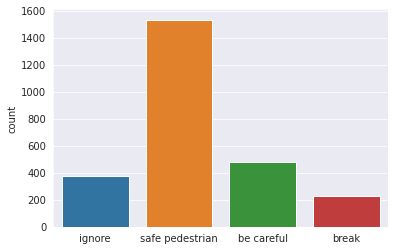

In [8]:
l = []
for i in trainDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

<AxesSubplot:ylabel='count'>

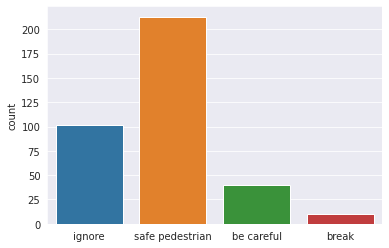

In [9]:
l = []
for i in valDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [10]:
del l

In [11]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, label

def read_image(image_path, h, w):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return tf.image.resize(image, [h, w])

def load_image(image_path, label, imageH, imageW):
    input_image = read_image(image_path, imageH, imageW)
    input_image, label = normalize(input_image, label)
    return input_image, label

In [12]:
dataset_train = tf.data.Dataset.from_tensor_slices((trainDataNames, trainDataLabels))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)


dataset_val = tf.data.Dataset.from_tensor_slices((valDataNames, valDataLabels))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

2022-11-13 20:05:17.645000: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [14]:
train_batches = (
        train_images
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [15]:
val_batches = val_images.batch(BATCH_SIZE)

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
base_model.trainable = True

In [18]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(4)                                     
                                ])

In [19]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss_weights=[1.5, 0.40, 1.7, 3.25],
              metrics=['accuracy'])


ep = 5
history = model.fit(train_batches,epochs = ep , validation_data = val_batches, steps_per_epoch=STEPS_PER_EPOCH)

2022-11-13 20:05:20.167401: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  1/652 [..............................] - ETA: 2:08:04 - loss: 2.8454 - accuracy: 0.0000e+00

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/652 [..............................] - ETA: 17:32 - loss: 2.6957 - accuracy: 0.0000e+00  

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  3/652 [..............................] - ETA: 16:55 - loss: 2.6054 - accuracy: 0.0000e+00

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/652 [..............................] - ETA: 16:50 - loss: 2.6006 - accuracy: 0.0625    

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  5/652 [..............................] - ETA: 17:01 - loss: 2.5370 - accuracy: 0.1000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  6/652 [..............................] - ETA: 16:59 - loss: 2.5761 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  7/652 [..............................] - ETA: 16:53 - loss: 2.6331 - accuracy: 0.1071

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  8/652 [..............................] - ETA: 16:44 - loss: 2.6809 - accuracy: 0.0938

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  9/652 [..............................] - ETA: 17:01 - loss: 2.7389 - accuracy: 0.0833

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 10/652 [..............................] - ETA: 16:52 - loss: 2.6545 - accuracy: 0.1000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/652 [..............................] - ETA: 16:45 - loss: 2.7433 - accuracy: 0.0909

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 12/652 [..............................] - ETA: 16:43 - loss: 2.7806 - accuracy: 0.0833

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 13/652 [..............................] - ETA: 16:37 - loss: 2.7221 - accuracy: 0.1154

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 14/652 [..............................] - ETA: 16:31 - loss: 2.8078 - accuracy: 0.1071

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 15/652 [..............................] - ETA: 16:28 - loss: 2.7842 - accuracy: 0.1167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 16/652 [..............................] - ETA: 16:26 - loss: 2.7490 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 17/652 [..............................] - ETA: 16:21 - loss: 2.7320 - accuracy: 0.1324

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 18/652 [..............................] - ETA: 16:48 - loss: 2.6943 - accuracy: 0.1389

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 19/652 [..............................] - ETA: 16:43 - loss: 2.6865 - accuracy: 0.1579

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 20/652 [..............................] - ETA: 16:40 - loss: 2.6487 - accuracy: 0.1875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/652 [..............................] - ETA: 16:37 - loss: 2.6304 - accuracy: 0.1905

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 22/652 [>.............................] - ETA: 16:35 - loss: 2.6086 - accuracy: 0.1818

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 23/652 [>.............................] - ETA: 16:32 - loss: 2.6161 - accuracy: 0.1739

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 24/652 [>.............................] - ETA: 16:35 - loss: 2.5821 - accuracy: 0.1771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 25/652 [>.............................] - ETA: 16:34 - loss: 2.6010 - accuracy: 0.1700

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 26/652 [>.............................] - ETA: 16:32 - loss: 2.5945 - accuracy: 0.1635

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 27/652 [>.............................] - ETA: 16:28 - loss: 2.6122 - accuracy: 0.1574

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 28/652 [>.............................] - ETA: 16:25 - loss: 2.6283 - accuracy: 0.1518

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/652 [>.............................] - ETA: 16:21 - loss: 2.6039 - accuracy: 0.1638

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 30/652 [>.............................] - ETA: 16:19 - loss: 2.5884 - accuracy: 0.1583

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 31/652 [>.............................] - ETA: 16:16 - loss: 2.6003 - accuracy: 0.1532

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/652 [>.............................] - ETA: 16:14 - loss: 2.6195 - accuracy: 0.1484

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 33/652 [>.............................] - ETA: 16:11 - loss: 2.6002 - accuracy: 0.1515

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 34/652 [>.............................] - ETA: 16:08 - loss: 2.6112 - accuracy: 0.1471

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/652 [>.............................] - ETA: 16:05 - loss: 2.6120 - accuracy: 0.1500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 36/652 [>.............................] - ETA: 16:02 - loss: 2.6221 - accuracy: 0.1458

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 37/652 [>.............................] - ETA: 15:59 - loss: 2.5923 - accuracy: 0.1554

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 38/652 [>.............................] - ETA: 16:08 - loss: 2.5856 - accuracy: 0.1579

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 39/652 [>.............................] - ETA: 16:06 - loss: 2.5799 - accuracy: 0.1603

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/652 [>.............................] - ETA: 16:03 - loss: 2.5777 - accuracy: 0.1562

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 41/652 [>.............................] - ETA: 16:01 - loss: 2.5829 - accuracy: 0.1585

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 42/652 [>.............................] - ETA: 15:58 - loss: 2.5797 - accuracy: 0.1548

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 43/652 [>.............................] - ETA: 15:55 - loss: 2.5534 - accuracy: 0.1628

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 44/652 [=>............................] - ETA: 15:52 - loss: 2.5565 - accuracy: 0.1648

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 45/652 [=>............................] - ETA: 15:50 - loss: 2.5438 - accuracy: 0.1722

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 46/652 [=>............................] - ETA: 15:47 - loss: 2.5513 - accuracy: 0.1685

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 47/652 [=>............................] - ETA: 15:46 - loss: 2.5519 - accuracy: 0.1702

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 48/652 [=>............................] - ETA: 15:44 - loss: 2.5555 - accuracy: 0.1719

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/652 [=>............................] - ETA: 15:41 - loss: 2.5328 - accuracy: 0.1735

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 50/652 [=>............................] - ETA: 15:39 - loss: 2.5263 - accuracy: 0.1700

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 51/652 [=>............................] - ETA: 15:37 - loss: 2.5091 - accuracy: 0.1765

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/652 [=>............................] - ETA: 15:35 - loss: 2.5049 - accuracy: 0.1779

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 53/652 [=>............................] - ETA: 15:33 - loss: 2.4966 - accuracy: 0.1792

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 54/652 [=>............................] - ETA: 15:31 - loss: 2.4875 - accuracy: 0.1759

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/652 [=>............................] - ETA: 15:30 - loss: 2.4874 - accuracy: 0.1727

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 56/652 [=>............................] - ETA: 15:28 - loss: 2.4633 - accuracy: 0.1830

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/652 [=>............................] - ETA: 15:25 - loss: 2.4527 - accuracy: 0.1842

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 58/652 [=>............................] - ETA: 15:31 - loss: 2.4505 - accuracy: 0.1810

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 59/652 [=>............................] - ETA: 15:30 - loss: 2.4399 - accuracy: 0.1822

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 60/652 [=>............................] - ETA: 15:28 - loss: 2.4329 - accuracy: 0.1833

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 61/652 [=>............................] - ETA: 15:27 - loss: 2.4309 - accuracy: 0.1803

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 62/652 [=>............................] - ETA: 15:25 - loss: 2.4245 - accuracy: 0.1774

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 63/652 [=>............................] - ETA: 15:24 - loss: 2.4176 - accuracy: 0.1786

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 64/652 [=>............................] - ETA: 15:22 - loss: 2.4142 - accuracy: 0.1758

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 65/652 [=>............................] - ETA: 15:20 - loss: 2.4043 - accuracy: 0.1808

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 66/652 [==>...........................] - ETA: 15:18 - loss: 2.4041 - accuracy: 0.1818

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 67/652 [==>...........................] - ETA: 15:16 - loss: 2.3998 - accuracy: 0.1828

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/652 [==>...........................] - ETA: 15:15 - loss: 2.3848 - accuracy: 0.1875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 69/652 [==>...........................] - ETA: 15:13 - loss: 2.3751 - accuracy: 0.1920

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/652 [==>...........................] - ETA: 15:11 - loss: 2.3778 - accuracy: 0.1893

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 71/652 [==>...........................] - ETA: 15:09 - loss: 2.3650 - accuracy: 0.1937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 72/652 [==>...........................] - ETA: 15:07 - loss: 2.3653 - accuracy: 0.1944

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 73/652 [==>...........................] - ETA: 15:05 - loss: 2.3592 - accuracy: 0.1952

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 74/652 [==>...........................] - ETA: 15:04 - loss: 2.3520 - accuracy: 0.1993

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 75/652 [==>...........................] - ETA: 15:02 - loss: 2.3467 - accuracy: 0.2000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 76/652 [==>...........................] - ETA: 15:00 - loss: 2.3421 - accuracy: 0.1974

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 77/652 [==>...........................] - ETA: 15:00 - loss: 2.3372 - accuracy: 0.1981

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 78/652 [==>...........................] - ETA: 15:02 - loss: 2.3307 - accuracy: 0.1987

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 79/652 [==>...........................] - ETA: 15:00 - loss: 2.3263 - accuracy: 0.1994

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 80/652 [==>...........................] - ETA: 14:58 - loss: 2.3206 - accuracy: 0.2000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 81/652 [==>...........................] - ETA: 14:56 - loss: 2.3112 - accuracy: 0.2037

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 82/652 [==>...........................] - ETA: 14:55 - loss: 2.3035 - accuracy: 0.2073

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 83/652 [==>...........................] - ETA: 14:53 - loss: 2.2998 - accuracy: 0.2108

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 84/652 [==>...........................] - ETA: 14:51 - loss: 2.2936 - accuracy: 0.2113

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/652 [==>...........................] - ETA: 14:48 - loss: 2.2859 - accuracy: 0.2088

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/652 [==>...........................] - ETA: 14:47 - loss: 2.2818 - accuracy: 0.2064

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 87/652 [===>..........................] - ETA: 14:45 - loss: 2.2845 - accuracy: 0.2069

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 88/652 [===>..........................] - ETA: 14:43 - loss: 2.2844 - accuracy: 0.2045

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/652 [===>..........................] - ETA: 14:42 - loss: 2.2848 - accuracy: 0.2022

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/652 [===>..........................] - ETA: 14:40 - loss: 2.2809 - accuracy: 0.2028

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 91/652 [===>..........................] - ETA: 14:38 - loss: 2.2757 - accuracy: 0.2033

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 92/652 [===>..........................] - ETA: 14:36 - loss: 2.2734 - accuracy: 0.2011

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 93/652 [===>..........................] - ETA: 14:34 - loss: 2.2682 - accuracy: 0.2043

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 94/652 [===>..........................] - ETA: 14:32 - loss: 2.2708 - accuracy: 0.2048

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 95/652 [===>..........................] - ETA: 14:30 - loss: 2.2633 - accuracy: 0.2079

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/652 [===>..........................] - ETA: 14:29 - loss: 2.2595 - accuracy: 0.2083

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/652 [===>..........................] - ETA: 14:27 - loss: 2.2552 - accuracy: 0.2088

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/652 [===>..........................] - ETA: 14:29 - loss: 2.2471 - accuracy: 0.2092

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 99/652 [===>..........................] - ETA: 14:27 - loss: 2.2455 - accuracy: 0.2146

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


100/652 [===>..........................] - ETA: 14:25 - loss: 2.2449 - accuracy: 0.2150

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


101/652 [===>..........................] - ETA: 14:23 - loss: 2.2434 - accuracy: 0.2129

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


102/652 [===>..........................] - ETA: 14:21 - loss: 2.2394 - accuracy: 0.2132

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


103/652 [===>..........................] - ETA: 14:20 - loss: 2.2380 - accuracy: 0.2160

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


104/652 [===>..........................] - ETA: 14:18 - loss: 2.2329 - accuracy: 0.2188

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


105/652 [===>..........................] - ETA: 14:16 - loss: 2.2320 - accuracy: 0.2167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/652 [===>..........................] - ETA: 14:14 - loss: 2.2289 - accuracy: 0.2193

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


107/652 [===>..........................] - ETA: 14:12 - loss: 2.2266 - accuracy: 0.2196

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


108/652 [===>..........................] - ETA: 14:10 - loss: 2.2242 - accuracy: 0.2199

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


109/652 [====>.........................] - ETA: 14:08 - loss: 2.2221 - accuracy: 0.2202

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


110/652 [====>.........................] - ETA: 14:06 - loss: 2.2213 - accuracy: 0.2205

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


111/652 [====>.........................] - ETA: 14:05 - loss: 2.2267 - accuracy: 0.2207

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


112/652 [====>.........................] - ETA: 14:03 - loss: 2.2215 - accuracy: 0.2210

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


113/652 [====>.........................] - ETA: 14:01 - loss: 2.2294 - accuracy: 0.2190

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


114/652 [====>.........................] - ETA: 13:59 - loss: 2.2368 - accuracy: 0.2171

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


115/652 [====>.........................] - ETA: 13:58 - loss: 2.2367 - accuracy: 0.2174

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


116/652 [====>.........................] - ETA: 13:56 - loss: 2.2372 - accuracy: 0.2177

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


117/652 [====>.........................] - ETA: 13:54 - loss: 2.2392 - accuracy: 0.2179

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


118/652 [====>.........................] - ETA: 13:56 - loss: 2.2416 - accuracy: 0.2182

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


119/652 [====>.........................] - ETA: 13:54 - loss: 2.2412 - accuracy: 0.2185

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


120/652 [====>.........................] - ETA: 13:53 - loss: 2.2388 - accuracy: 0.2167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


121/652 [====>.........................] - ETA: 13:51 - loss: 2.2336 - accuracy: 0.2169

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


122/652 [====>.........................] - ETA: 13:49 - loss: 2.2370 - accuracy: 0.2152

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


123/652 [====>.........................] - ETA: 13:47 - loss: 2.2434 - accuracy: 0.2134

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


124/652 [====>.........................] - ETA: 13:46 - loss: 2.2416 - accuracy: 0.2137

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


125/652 [====>.........................] - ETA: 13:44 - loss: 2.2393 - accuracy: 0.2140

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


126/652 [====>.........................] - ETA: 13:42 - loss: 2.2362 - accuracy: 0.2163

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


127/652 [====>.........................] - ETA: 13:40 - loss: 2.2318 - accuracy: 0.2146

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


128/652 [====>.........................] - ETA: 13:38 - loss: 2.2327 - accuracy: 0.2129

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


129/652 [====>.........................] - ETA: 13:36 - loss: 2.2327 - accuracy: 0.2132

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


130/652 [====>.........................] - ETA: 13:34 - loss: 2.2303 - accuracy: 0.2135

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


131/652 [=====>........................] - ETA: 13:33 - loss: 2.2282 - accuracy: 0.2137

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


132/652 [=====>........................] - ETA: 13:32 - loss: 2.2305 - accuracy: 0.2121

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


133/652 [=====>........................] - ETA: 13:30 - loss: 2.2287 - accuracy: 0.2143

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


134/652 [=====>........................] - ETA: 13:28 - loss: 2.2219 - accuracy: 0.2164

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


135/652 [=====>........................] - ETA: 13:26 - loss: 2.2168 - accuracy: 0.2167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


136/652 [=====>........................] - ETA: 13:24 - loss: 2.2139 - accuracy: 0.2169

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


137/652 [=====>........................] - ETA: 13:23 - loss: 2.2125 - accuracy: 0.2172

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


138/652 [=====>........................] - ETA: 13:24 - loss: 2.2106 - accuracy: 0.2192

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


139/652 [=====>........................] - ETA: 13:22 - loss: 2.2144 - accuracy: 0.2176

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


140/652 [=====>........................] - ETA: 13:20 - loss: 2.2138 - accuracy: 0.2196

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


141/652 [=====>........................] - ETA: 13:19 - loss: 2.2123 - accuracy: 0.2216

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


142/652 [=====>........................] - ETA: 13:17 - loss: 2.2139 - accuracy: 0.2218

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


143/652 [=====>........................] - ETA: 13:15 - loss: 2.2106 - accuracy: 0.2220

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


144/652 [=====>........................] - ETA: 13:13 - loss: 2.2069 - accuracy: 0.2222

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


145/652 [=====>........................] - ETA: 13:11 - loss: 2.2042 - accuracy: 0.2207

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


146/652 [=====>........................] - ETA: 13:09 - loss: 2.2023 - accuracy: 0.2243

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


147/652 [=====>........................] - ETA: 13:08 - loss: 2.2016 - accuracy: 0.2245

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


148/652 [=====>........................] - ETA: 13:06 - loss: 2.1997 - accuracy: 0.2247

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


149/652 [=====>........................] - ETA: 13:04 - loss: 2.2026 - accuracy: 0.2232

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


150/652 [=====>........................] - ETA: 13:03 - loss: 2.2032 - accuracy: 0.2233

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


151/652 [=====>........................] - ETA: 13:01 - loss: 2.2014 - accuracy: 0.2219

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


152/652 [=====>........................] - ETA: 12:59 - loss: 2.1977 - accuracy: 0.2220

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


153/652 [======>.......................] - ETA: 12:57 - loss: 2.1965 - accuracy: 0.2222

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


154/652 [======>.......................] - ETA: 12:55 - loss: 2.1914 - accuracy: 0.2273

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


155/652 [======>.......................] - ETA: 12:54 - loss: 2.1973 - accuracy: 0.2258

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


156/652 [======>.......................] - ETA: 12:52 - loss: 2.1979 - accuracy: 0.2276

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


157/652 [======>.......................] - ETA: 12:50 - loss: 2.1977 - accuracy: 0.2261

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


158/652 [======>.......................] - ETA: 12:50 - loss: 2.1974 - accuracy: 0.2278

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


159/652 [======>.......................] - ETA: 12:49 - loss: 2.1955 - accuracy: 0.2280

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


160/652 [======>.......................] - ETA: 12:47 - loss: 2.1912 - accuracy: 0.2297

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


161/652 [======>.......................] - ETA: 12:45 - loss: 2.1900 - accuracy: 0.2298

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


162/652 [======>.......................] - ETA: 12:43 - loss: 2.1869 - accuracy: 0.2315

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


163/652 [======>.......................] - ETA: 12:42 - loss: 2.1854 - accuracy: 0.2301

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


164/652 [======>.......................] - ETA: 12:40 - loss: 2.1832 - accuracy: 0.2302

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


165/652 [======>.......................] - ETA: 12:38 - loss: 2.1838 - accuracy: 0.2318

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


166/652 [======>.......................] - ETA: 12:36 - loss: 2.1832 - accuracy: 0.2319

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


167/652 [======>.......................] - ETA: 12:34 - loss: 2.1801 - accuracy: 0.2335

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


168/652 [======>.......................] - ETA: 12:33 - loss: 2.1771 - accuracy: 0.2351

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


169/652 [======>.......................] - ETA: 12:31 - loss: 2.1760 - accuracy: 0.2352

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


170/652 [======>.......................] - ETA: 12:29 - loss: 2.1713 - accuracy: 0.2368

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


171/652 [======>.......................] - ETA: 12:27 - loss: 2.1695 - accuracy: 0.2368

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


172/652 [======>.......................] - ETA: 12:25 - loss: 2.1669 - accuracy: 0.2384

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


173/652 [======>.......................] - ETA: 12:24 - loss: 2.1631 - accuracy: 0.2399

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


174/652 [=======>......................] - ETA: 12:22 - loss: 2.1625 - accuracy: 0.2399

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


175/652 [=======>......................] - ETA: 12:21 - loss: 2.1637 - accuracy: 0.2400

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


176/652 [=======>......................] - ETA: 12:19 - loss: 2.1639 - accuracy: 0.2401

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


177/652 [=======>......................] - ETA: 12:18 - loss: 2.1611 - accuracy: 0.2429

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


178/652 [=======>......................] - ETA: 12:16 - loss: 2.1597 - accuracy: 0.2430

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


179/652 [=======>......................] - ETA: 12:17 - loss: 2.1598 - accuracy: 0.2416

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


180/652 [=======>......................] - ETA: 12:15 - loss: 2.1559 - accuracy: 0.2431

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


181/652 [=======>......................] - ETA: 12:13 - loss: 2.1511 - accuracy: 0.2459

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


182/652 [=======>......................] - ETA: 12:12 - loss: 2.1553 - accuracy: 0.2445

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


183/652 [=======>......................] - ETA: 12:10 - loss: 2.1536 - accuracy: 0.2432

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


184/652 [=======>......................] - ETA: 12:09 - loss: 2.1510 - accuracy: 0.2432

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


185/652 [=======>......................] - ETA: 12:07 - loss: 2.1493 - accuracy: 0.2432

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


186/652 [=======>......................] - ETA: 12:05 - loss: 2.1495 - accuracy: 0.2419

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


187/652 [=======>......................] - ETA: 12:04 - loss: 2.1535 - accuracy: 0.2406

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


188/652 [=======>......................] - ETA: 12:02 - loss: 2.1489 - accuracy: 0.2447

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


189/652 [=======>......................] - ETA: 12:00 - loss: 2.1473 - accuracy: 0.2447

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


190/652 [=======>......................] - ETA: 11:59 - loss: 2.1441 - accuracy: 0.2461

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


191/652 [=======>......................] - ETA: 11:57 - loss: 2.1419 - accuracy: 0.2474

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


192/652 [=======>......................] - ETA: 11:55 - loss: 2.1419 - accuracy: 0.2461

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


193/652 [=======>......................] - ETA: 11:53 - loss: 2.1395 - accuracy: 0.2487

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


194/652 [=======>......................] - ETA: 11:52 - loss: 2.1406 - accuracy: 0.2474

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


195/652 [=======>......................] - ETA: 11:50 - loss: 2.1396 - accuracy: 0.2474

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


196/652 [========>.....................] - ETA: 11:49 - loss: 2.1413 - accuracy: 0.2474

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


197/652 [========>.....................] - ETA: 11:47 - loss: 2.1443 - accuracy: 0.2462

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


198/652 [========>.....................] - ETA: 11:45 - loss: 2.1438 - accuracy: 0.2449

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


199/652 [========>.....................] - ETA: 11:45 - loss: 2.1417 - accuracy: 0.2462

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


200/652 [========>.....................] - ETA: 11:43 - loss: 2.1425 - accuracy: 0.2463

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


201/652 [========>.....................] - ETA: 11:41 - loss: 2.1440 - accuracy: 0.2463

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


202/652 [========>.....................] - ETA: 11:40 - loss: 2.1453 - accuracy: 0.2463

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


203/652 [========>.....................] - ETA: 11:38 - loss: 2.1438 - accuracy: 0.2475

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


204/652 [========>.....................] - ETA: 11:36 - loss: 2.1484 - accuracy: 0.2463

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


205/652 [========>.....................] - ETA: 11:35 - loss: 2.1440 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


206/652 [========>.....................] - ETA: 11:33 - loss: 2.1451 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


207/652 [========>.....................] - ETA: 11:31 - loss: 2.1447 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


208/652 [========>.....................] - ETA: 11:29 - loss: 2.1411 - accuracy: 0.2524

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


209/652 [========>.....................] - ETA: 11:28 - loss: 2.1426 - accuracy: 0.2524

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


210/652 [========>.....................] - ETA: 11:26 - loss: 2.1423 - accuracy: 0.2524

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


211/652 [========>.....................] - ETA: 11:24 - loss: 2.1411 - accuracy: 0.2536

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


212/652 [========>.....................] - ETA: 11:23 - loss: 2.1403 - accuracy: 0.2547

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


213/652 [========>.....................] - ETA: 11:21 - loss: 2.1401 - accuracy: 0.2535

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


214/652 [========>.....................] - ETA: 11:19 - loss: 2.1434 - accuracy: 0.2535

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


215/652 [========>.....................] - ETA: 11:17 - loss: 2.1439 - accuracy: 0.2523

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


216/652 [========>.....................] - ETA: 11:16 - loss: 2.1416 - accuracy: 0.2523

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


217/652 [========>.....................] - ETA: 11:14 - loss: 2.1389 - accuracy: 0.2535

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


218/652 [=========>....................] - ETA: 11:12 - loss: 2.1421 - accuracy: 0.2523

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


219/652 [=========>....................] - ETA: 11:11 - loss: 2.1420 - accuracy: 0.2523

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


220/652 [=========>....................] - ETA: 11:10 - loss: 2.1388 - accuracy: 0.2545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


221/652 [=========>....................] - ETA: 11:09 - loss: 2.1402 - accuracy: 0.2545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


222/652 [=========>....................] - ETA: 11:07 - loss: 2.1390 - accuracy: 0.2556

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


223/652 [=========>....................] - ETA: 11:05 - loss: 2.1397 - accuracy: 0.2545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


224/652 [=========>....................] - ETA: 11:04 - loss: 2.1372 - accuracy: 0.2567

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


225/652 [=========>....................] - ETA: 11:02 - loss: 2.1353 - accuracy: 0.2567

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


226/652 [=========>....................] - ETA: 11:00 - loss: 2.1365 - accuracy: 0.2566

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


227/652 [=========>....................] - ETA: 10:59 - loss: 2.1354 - accuracy: 0.2577

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


228/652 [=========>....................] - ETA: 10:57 - loss: 2.1322 - accuracy: 0.2599

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


229/652 [=========>....................] - ETA: 10:55 - loss: 2.1307 - accuracy: 0.2609

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


230/652 [=========>....................] - ETA: 10:54 - loss: 2.1285 - accuracy: 0.2620

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


231/652 [=========>....................] - ETA: 10:52 - loss: 2.1270 - accuracy: 0.2630

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


232/652 [=========>....................] - ETA: 10:51 - loss: 2.1278 - accuracy: 0.2640

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


233/652 [=========>....................] - ETA: 10:49 - loss: 2.1347 - accuracy: 0.2629

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


234/652 [=========>....................] - ETA: 10:47 - loss: 2.1327 - accuracy: 0.2628

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


235/652 [=========>....................] - ETA: 10:46 - loss: 2.1341 - accuracy: 0.2628

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


236/652 [=========>....................] - ETA: 10:44 - loss: 2.1305 - accuracy: 0.2638

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


237/652 [=========>....................] - ETA: 10:42 - loss: 2.1273 - accuracy: 0.2658

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


238/652 [=========>....................] - ETA: 10:41 - loss: 2.1256 - accuracy: 0.2668

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


239/652 [=========>....................] - ETA: 10:39 - loss: 2.1261 - accuracy: 0.2667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


240/652 [==========>...................] - ETA: 10:39 - loss: 2.1243 - accuracy: 0.2677

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


241/652 [==========>...................] - ETA: 10:37 - loss: 2.1253 - accuracy: 0.2666

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


242/652 [==========>...................] - ETA: 10:35 - loss: 2.1244 - accuracy: 0.2665

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


243/652 [==========>...................] - ETA: 10:34 - loss: 2.1227 - accuracy: 0.2675

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


244/652 [==========>...................] - ETA: 10:32 - loss: 2.1193 - accuracy: 0.2705

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


245/652 [==========>...................] - ETA: 10:31 - loss: 2.1198 - accuracy: 0.2704

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


246/652 [==========>...................] - ETA: 10:29 - loss: 2.1168 - accuracy: 0.2724

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


247/652 [==========>...................] - ETA: 10:27 - loss: 2.1167 - accuracy: 0.2713

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


248/652 [==========>...................] - ETA: 10:26 - loss: 2.1141 - accuracy: 0.2742

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


249/652 [==========>...................] - ETA: 10:24 - loss: 2.1132 - accuracy: 0.2751

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


250/652 [==========>...................] - ETA: 10:22 - loss: 2.1164 - accuracy: 0.2750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


251/652 [==========>...................] - ETA: 10:21 - loss: 2.1146 - accuracy: 0.2759

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


252/652 [==========>...................] - ETA: 10:19 - loss: 2.1198 - accuracy: 0.2748

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


253/652 [==========>...................] - ETA: 10:18 - loss: 2.1183 - accuracy: 0.2747

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


254/652 [==========>...................] - ETA: 10:16 - loss: 2.1168 - accuracy: 0.2756

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


255/652 [==========>...................] - ETA: 10:14 - loss: 2.1147 - accuracy: 0.2765

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


256/652 [==========>...................] - ETA: 10:13 - loss: 2.1151 - accuracy: 0.2773

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


257/652 [==========>...................] - ETA: 10:11 - loss: 2.1173 - accuracy: 0.2772

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


258/652 [==========>...................] - ETA: 10:10 - loss: 2.1161 - accuracy: 0.2771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


259/652 [==========>...................] - ETA: 10:08 - loss: 2.1149 - accuracy: 0.2780

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


260/652 [==========>...................] - ETA: 10:08 - loss: 2.1127 - accuracy: 0.2798

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


261/652 [===========>..................] - ETA: 10:06 - loss: 2.1105 - accuracy: 0.2807

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


262/652 [===========>..................] - ETA: 10:04 - loss: 2.1101 - accuracy: 0.2805

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


263/652 [===========>..................] - ETA: 10:03 - loss: 2.1081 - accuracy: 0.2814

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


264/652 [===========>..................] - ETA: 10:01 - loss: 2.1066 - accuracy: 0.2812

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


265/652 [===========>..................] - ETA: 9:59 - loss: 2.1070 - accuracy: 0.2821 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


266/652 [===========>..................] - ETA: 9:58 - loss: 2.1079 - accuracy: 0.2829

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


267/652 [===========>..................] - ETA: 9:56 - loss: 2.1062 - accuracy: 0.2837

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


268/652 [===========>..................] - ETA: 9:54 - loss: 2.1033 - accuracy: 0.2845

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


269/652 [===========>..................] - ETA: 9:53 - loss: 2.1014 - accuracy: 0.2853

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


270/652 [===========>..................] - ETA: 9:51 - loss: 2.1009 - accuracy: 0.2861

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


271/652 [===========>..................] - ETA: 9:50 - loss: 2.0984 - accuracy: 0.2869

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


272/652 [===========>..................] - ETA: 9:48 - loss: 2.0970 - accuracy: 0.2877

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


273/652 [===========>..................] - ETA: 9:46 - loss: 2.0961 - accuracy: 0.2875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


274/652 [===========>..................] - ETA: 9:45 - loss: 2.0949 - accuracy: 0.2883

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


275/652 [===========>..................] - ETA: 9:43 - loss: 2.0953 - accuracy: 0.2891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


276/652 [===========>..................] - ETA: 9:42 - loss: 2.0931 - accuracy: 0.2899

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


277/652 [===========>..................] - ETA: 9:40 - loss: 2.0905 - accuracy: 0.2906

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


278/652 [===========>..................] - ETA: 9:38 - loss: 2.0884 - accuracy: 0.2914

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


279/652 [===========>..................] - ETA: 9:37 - loss: 2.0883 - accuracy: 0.2903

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


280/652 [===========>..................] - ETA: 9:35 - loss: 2.0877 - accuracy: 0.2902

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


281/652 [===========>..................] - ETA: 9:35 - loss: 2.0878 - accuracy: 0.2891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


282/652 [===========>..................] - ETA: 9:33 - loss: 2.0858 - accuracy: 0.2908

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


283/652 [============>.................] - ETA: 9:31 - loss: 2.0861 - accuracy: 0.2906

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


284/652 [============>.................] - ETA: 9:30 - loss: 2.0870 - accuracy: 0.2914

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


285/652 [============>.................] - ETA: 9:28 - loss: 2.0856 - accuracy: 0.2921

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


286/652 [============>.................] - ETA: 9:27 - loss: 2.0823 - accuracy: 0.2946

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


287/652 [============>.................] - ETA: 9:25 - loss: 2.0807 - accuracy: 0.2953

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


288/652 [============>.................] - ETA: 9:24 - loss: 2.0788 - accuracy: 0.2960

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


289/652 [============>.................] - ETA: 9:22 - loss: 2.0767 - accuracy: 0.2976

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


290/652 [============>.................] - ETA: 9:21 - loss: 2.0764 - accuracy: 0.2983

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


291/652 [============>.................] - ETA: 9:19 - loss: 2.0725 - accuracy: 0.3007

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


292/652 [============>.................] - ETA: 9:18 - loss: 2.0702 - accuracy: 0.3022

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


293/652 [============>.................] - ETA: 9:16 - loss: 2.0696 - accuracy: 0.3020

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


294/652 [============>.................] - ETA: 9:14 - loss: 2.0679 - accuracy: 0.3027

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


295/652 [============>.................] - ETA: 9:13 - loss: 2.0663 - accuracy: 0.3034

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


296/652 [============>.................] - ETA: 9:11 - loss: 2.0642 - accuracy: 0.3032

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


297/652 [============>.................] - ETA: 9:10 - loss: 2.0617 - accuracy: 0.3039

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


298/652 [============>.................] - ETA: 9:08 - loss: 2.0622 - accuracy: 0.3029

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


299/652 [============>.................] - ETA: 9:07 - loss: 2.0610 - accuracy: 0.3035

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


300/652 [============>.................] - ETA: 9:05 - loss: 2.0620 - accuracy: 0.3025

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


301/652 [============>.................] - ETA: 9:04 - loss: 2.0611 - accuracy: 0.3032

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


302/652 [============>.................] - ETA: 9:03 - loss: 2.0616 - accuracy: 0.3038

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


303/652 [============>.................] - ETA: 9:01 - loss: 2.0632 - accuracy: 0.3036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


304/652 [============>.................] - ETA: 8:59 - loss: 2.0647 - accuracy: 0.3043

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


305/652 [=============>................] - ETA: 8:58 - loss: 2.0632 - accuracy: 0.3049

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


306/652 [=============>................] - ETA: 8:56 - loss: 2.0608 - accuracy: 0.3064

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


307/652 [=============>................] - ETA: 8:55 - loss: 2.0605 - accuracy: 0.3062

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


308/652 [=============>................] - ETA: 8:53 - loss: 2.0594 - accuracy: 0.3068

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


309/652 [=============>................] - ETA: 8:51 - loss: 2.0605 - accuracy: 0.3066

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


310/652 [=============>................] - ETA: 8:50 - loss: 2.0621 - accuracy: 0.3056

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


311/652 [=============>................] - ETA: 8:48 - loss: 2.0620 - accuracy: 0.3063

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


312/652 [=============>................] - ETA: 8:47 - loss: 2.0612 - accuracy: 0.3077

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


313/652 [=============>................] - ETA: 8:45 - loss: 2.0646 - accuracy: 0.3067

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


314/652 [=============>................] - ETA: 8:43 - loss: 2.0650 - accuracy: 0.3065

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


315/652 [=============>................] - ETA: 8:42 - loss: 2.0646 - accuracy: 0.3071

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


316/652 [=============>................] - ETA: 8:40 - loss: 2.0636 - accuracy: 0.3070

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


317/652 [=============>................] - ETA: 8:39 - loss: 2.0641 - accuracy: 0.3084

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


318/652 [=============>................] - ETA: 8:37 - loss: 2.0646 - accuracy: 0.3082

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


319/652 [=============>................] - ETA: 8:35 - loss: 2.0621 - accuracy: 0.3103

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


320/652 [=============>................] - ETA: 8:34 - loss: 2.0643 - accuracy: 0.3094

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


321/652 [=============>................] - ETA: 8:33 - loss: 2.0639 - accuracy: 0.3092

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


322/652 [=============>................] - ETA: 8:31 - loss: 2.0630 - accuracy: 0.3098

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


323/652 [=============>................] - ETA: 8:30 - loss: 2.0615 - accuracy: 0.3111

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


324/652 [=============>................] - ETA: 8:28 - loss: 2.0626 - accuracy: 0.3102

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


325/652 [=============>................] - ETA: 8:27 - loss: 2.0606 - accuracy: 0.3123

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


326/652 [==============>...............] - ETA: 8:25 - loss: 2.0611 - accuracy: 0.3121

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


327/652 [==============>...............] - ETA: 8:23 - loss: 2.0599 - accuracy: 0.3135

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


328/652 [==============>...............] - ETA: 8:22 - loss: 2.0603 - accuracy: 0.3133

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


329/652 [==============>...............] - ETA: 8:20 - loss: 2.0595 - accuracy: 0.3146

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


330/652 [==============>...............] - ETA: 8:19 - loss: 2.0581 - accuracy: 0.3159

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


331/652 [==============>...............] - ETA: 8:17 - loss: 2.0569 - accuracy: 0.3165

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


332/652 [==============>...............] - ETA: 8:16 - loss: 2.0549 - accuracy: 0.3185

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


333/652 [==============>...............] - ETA: 8:14 - loss: 2.0595 - accuracy: 0.3176

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


334/652 [==============>...............] - ETA: 8:12 - loss: 2.0594 - accuracy: 0.3181

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


335/652 [==============>...............] - ETA: 8:11 - loss: 2.0594 - accuracy: 0.3179

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


336/652 [==============>...............] - ETA: 8:09 - loss: 2.0596 - accuracy: 0.3185

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


337/652 [==============>...............] - ETA: 8:08 - loss: 2.0577 - accuracy: 0.3190

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


338/652 [==============>...............] - ETA: 8:06 - loss: 2.0573 - accuracy: 0.3180

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


339/652 [==============>...............] - ETA: 8:04 - loss: 2.0574 - accuracy: 0.3178

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


340/652 [==============>...............] - ETA: 8:03 - loss: 2.0549 - accuracy: 0.3199

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


341/652 [==============>...............] - ETA: 8:02 - loss: 2.0538 - accuracy: 0.3204

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


342/652 [==============>...............] - ETA: 8:00 - loss: 2.0529 - accuracy: 0.3209

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


343/652 [==============>...............] - ETA: 7:59 - loss: 2.0520 - accuracy: 0.3207

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


344/652 [==============>...............] - ETA: 7:57 - loss: 2.0500 - accuracy: 0.3219

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


345/652 [==============>...............] - ETA: 7:56 - loss: 2.0498 - accuracy: 0.3217

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


346/652 [==============>...............] - ETA: 7:54 - loss: 2.0490 - accuracy: 0.3223

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


347/652 [==============>...............] - ETA: 7:52 - loss: 2.0485 - accuracy: 0.3228

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


348/652 [===============>..............] - ETA: 7:51 - loss: 2.0476 - accuracy: 0.3226

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


349/652 [===============>..............] - ETA: 7:49 - loss: 2.0482 - accuracy: 0.3223

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


350/652 [===============>..............] - ETA: 7:48 - loss: 2.0478 - accuracy: 0.3229

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


351/652 [===============>..............] - ETA: 7:46 - loss: 2.0482 - accuracy: 0.3234

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


352/652 [===============>..............] - ETA: 7:45 - loss: 2.0470 - accuracy: 0.3246

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


353/652 [===============>..............] - ETA: 7:43 - loss: 2.0477 - accuracy: 0.3244

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


354/652 [===============>..............] - ETA: 7:41 - loss: 2.0486 - accuracy: 0.3242

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


355/652 [===============>..............] - ETA: 7:40 - loss: 2.0482 - accuracy: 0.3246

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


356/652 [===============>..............] - ETA: 7:38 - loss: 2.0486 - accuracy: 0.3244

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


357/652 [===============>..............] - ETA: 7:37 - loss: 2.0486 - accuracy: 0.3235

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


358/652 [===============>..............] - ETA: 7:35 - loss: 2.0468 - accuracy: 0.3247

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


359/652 [===============>..............] - ETA: 7:33 - loss: 2.0461 - accuracy: 0.3252

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


360/652 [===============>..............] - ETA: 7:32 - loss: 2.0456 - accuracy: 0.3250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


361/652 [===============>..............] - ETA: 7:31 - loss: 2.0471 - accuracy: 0.3248

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


362/652 [===============>..............] - ETA: 7:29 - loss: 2.0475 - accuracy: 0.3239

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


363/652 [===============>..............] - ETA: 7:27 - loss: 2.0463 - accuracy: 0.3237

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


364/652 [===============>..............] - ETA: 7:26 - loss: 2.0450 - accuracy: 0.3242

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


365/652 [===============>..............] - ETA: 7:24 - loss: 2.0434 - accuracy: 0.3253

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


366/652 [===============>..............] - ETA: 7:23 - loss: 2.0437 - accuracy: 0.3258

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


367/652 [===============>..............] - ETA: 7:21 - loss: 2.0434 - accuracy: 0.3263

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


368/652 [===============>..............] - ETA: 7:20 - loss: 2.0423 - accuracy: 0.3261

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


369/652 [===============>..............] - ETA: 7:18 - loss: 2.0414 - accuracy: 0.3259

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


370/652 [================>.............] - ETA: 7:17 - loss: 2.0414 - accuracy: 0.3257

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


371/652 [================>.............] - ETA: 7:15 - loss: 2.0406 - accuracy: 0.3261

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


372/652 [================>.............] - ETA: 7:14 - loss: 2.0392 - accuracy: 0.3266

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


373/652 [================>.............] - ETA: 7:12 - loss: 2.0398 - accuracy: 0.3264

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


374/652 [================>.............] - ETA: 7:10 - loss: 2.0393 - accuracy: 0.3262

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


375/652 [================>.............] - ETA: 7:09 - loss: 2.0385 - accuracy: 0.3267

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


376/652 [================>.............] - ETA: 7:07 - loss: 2.0371 - accuracy: 0.3278

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


377/652 [================>.............] - ETA: 7:06 - loss: 2.0369 - accuracy: 0.3276

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


378/652 [================>.............] - ETA: 7:04 - loss: 2.0356 - accuracy: 0.3280

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


379/652 [================>.............] - ETA: 7:03 - loss: 2.0349 - accuracy: 0.3285

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


380/652 [================>.............] - ETA: 7:01 - loss: 2.0334 - accuracy: 0.3289

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


381/652 [================>.............] - ETA: 7:00 - loss: 2.0320 - accuracy: 0.3301

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


382/652 [================>.............] - ETA: 6:58 - loss: 2.0309 - accuracy: 0.3312

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


383/652 [================>.............] - ETA: 6:57 - loss: 2.0304 - accuracy: 0.3316

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


384/652 [================>.............] - ETA: 6:55 - loss: 2.0292 - accuracy: 0.3320

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


385/652 [================>.............] - ETA: 6:54 - loss: 2.0295 - accuracy: 0.3318

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


386/652 [================>.............] - ETA: 6:52 - loss: 2.0303 - accuracy: 0.3316

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


387/652 [================>.............] - ETA: 6:50 - loss: 2.0295 - accuracy: 0.3327

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


388/652 [================>.............] - ETA: 6:49 - loss: 2.0287 - accuracy: 0.3331

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


389/652 [================>.............] - ETA: 6:47 - loss: 2.0273 - accuracy: 0.3335

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


390/652 [================>.............] - ETA: 6:46 - loss: 2.0281 - accuracy: 0.3327

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


391/652 [================>.............] - ETA: 6:44 - loss: 2.0266 - accuracy: 0.3338

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


392/652 [=================>............] - ETA: 6:43 - loss: 2.0251 - accuracy: 0.3342

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


393/652 [=================>............] - ETA: 6:41 - loss: 2.0241 - accuracy: 0.3352

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


394/652 [=================>............] - ETA: 6:40 - loss: 2.0232 - accuracy: 0.3357

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


395/652 [=================>............] - ETA: 6:38 - loss: 2.0219 - accuracy: 0.3367

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


396/652 [=================>............] - ETA: 6:36 - loss: 2.0212 - accuracy: 0.3371

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


397/652 [=================>............] - ETA: 6:35 - loss: 2.0216 - accuracy: 0.3375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


398/652 [=================>............] - ETA: 6:33 - loss: 2.0222 - accuracy: 0.3379

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


399/652 [=================>............] - ETA: 6:32 - loss: 2.0224 - accuracy: 0.3377

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


400/652 [=================>............] - ETA: 6:30 - loss: 2.0210 - accuracy: 0.3381

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


401/652 [=================>............] - ETA: 6:29 - loss: 2.0209 - accuracy: 0.3379

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


402/652 [=================>............] - ETA: 6:28 - loss: 2.0203 - accuracy: 0.3377

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


403/652 [=================>............] - ETA: 6:26 - loss: 2.0195 - accuracy: 0.3387

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


404/652 [=================>............] - ETA: 6:24 - loss: 2.0204 - accuracy: 0.3379

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


405/652 [=================>............] - ETA: 6:23 - loss: 2.0184 - accuracy: 0.3389

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


406/652 [=================>............] - ETA: 6:21 - loss: 2.0166 - accuracy: 0.3399

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


407/652 [=================>............] - ETA: 6:20 - loss: 2.0165 - accuracy: 0.3397

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


408/652 [=================>............] - ETA: 6:18 - loss: 2.0172 - accuracy: 0.3395

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


409/652 [=================>............] - ETA: 6:17 - loss: 2.0169 - accuracy: 0.3392

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


410/652 [=================>............] - ETA: 6:15 - loss: 2.0168 - accuracy: 0.3390

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


411/652 [=================>............] - ETA: 6:14 - loss: 2.0158 - accuracy: 0.3394

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


412/652 [=================>............] - ETA: 6:12 - loss: 2.0143 - accuracy: 0.3404

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


413/652 [==================>...........] - ETA: 6:10 - loss: 2.0131 - accuracy: 0.3408

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


414/652 [==================>...........] - ETA: 6:09 - loss: 2.0125 - accuracy: 0.3412

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


415/652 [==================>...........] - ETA: 6:07 - loss: 2.0112 - accuracy: 0.3416

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


416/652 [==================>...........] - ETA: 6:06 - loss: 2.0101 - accuracy: 0.3425

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


417/652 [==================>...........] - ETA: 6:04 - loss: 2.0100 - accuracy: 0.3423

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


418/652 [==================>...........] - ETA: 6:03 - loss: 2.0078 - accuracy: 0.3439

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


419/652 [==================>...........] - ETA: 6:01 - loss: 2.0061 - accuracy: 0.3455

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


420/652 [==================>...........] - ETA: 5:59 - loss: 2.0051 - accuracy: 0.3458

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


421/652 [==================>...........] - ETA: 5:58 - loss: 2.0047 - accuracy: 0.3468

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


422/652 [==================>...........] - ETA: 5:57 - loss: 2.0037 - accuracy: 0.3477

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


423/652 [==================>...........] - ETA: 5:55 - loss: 2.0025 - accuracy: 0.3481

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


424/652 [==================>...........] - ETA: 5:54 - loss: 2.0027 - accuracy: 0.3479

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


425/652 [==================>...........] - ETA: 5:52 - loss: 2.0022 - accuracy: 0.3482

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


426/652 [==================>...........] - ETA: 5:50 - loss: 2.0017 - accuracy: 0.3486

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


427/652 [==================>...........] - ETA: 5:49 - loss: 2.0020 - accuracy: 0.3478

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


428/652 [==================>...........] - ETA: 5:47 - loss: 2.0013 - accuracy: 0.3487

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


429/652 [==================>...........] - ETA: 5:46 - loss: 1.9989 - accuracy: 0.3502

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


430/652 [==================>...........] - ETA: 5:44 - loss: 1.9971 - accuracy: 0.3512

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


431/652 [==================>...........] - ETA: 5:43 - loss: 1.9955 - accuracy: 0.3527

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


432/652 [==================>...........] - ETA: 5:41 - loss: 1.9941 - accuracy: 0.3536

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


433/652 [==================>...........] - ETA: 5:39 - loss: 1.9936 - accuracy: 0.3539

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


434/652 [==================>...........] - ETA: 5:38 - loss: 1.9933 - accuracy: 0.3537

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


435/652 [===================>..........] - ETA: 5:36 - loss: 1.9915 - accuracy: 0.3546

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


436/652 [===================>..........] - ETA: 5:35 - loss: 1.9917 - accuracy: 0.3544

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


437/652 [===================>..........] - ETA: 5:33 - loss: 1.9908 - accuracy: 0.3547

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


438/652 [===================>..........] - ETA: 5:31 - loss: 1.9908 - accuracy: 0.3550

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


439/652 [===================>..........] - ETA: 5:30 - loss: 1.9895 - accuracy: 0.3559

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


440/652 [===================>..........] - ETA: 5:28 - loss: 1.9872 - accuracy: 0.3574

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


441/652 [===================>..........] - ETA: 5:27 - loss: 1.9864 - accuracy: 0.3577

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


442/652 [===================>..........] - ETA: 5:26 - loss: 1.9860 - accuracy: 0.3586

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


443/652 [===================>..........] - ETA: 5:24 - loss: 1.9845 - accuracy: 0.3595

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


444/652 [===================>..........] - ETA: 5:22 - loss: 1.9831 - accuracy: 0.3604

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


445/652 [===================>..........] - ETA: 5:21 - loss: 1.9812 - accuracy: 0.3618

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


446/652 [===================>..........] - ETA: 5:19 - loss: 1.9791 - accuracy: 0.3632

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


447/652 [===================>..........] - ETA: 5:18 - loss: 1.9783 - accuracy: 0.3635

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


448/652 [===================>..........] - ETA: 5:16 - loss: 1.9765 - accuracy: 0.3644

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


449/652 [===================>..........] - ETA: 5:15 - loss: 1.9749 - accuracy: 0.3653

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


450/652 [===================>..........] - ETA: 5:13 - loss: 1.9743 - accuracy: 0.3656

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


451/652 [===================>..........] - ETA: 5:12 - loss: 1.9732 - accuracy: 0.3664

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


452/652 [===================>..........] - ETA: 5:10 - loss: 1.9722 - accuracy: 0.3667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


453/652 [===================>..........] - ETA: 5:08 - loss: 1.9717 - accuracy: 0.3670

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


454/652 [===================>..........] - ETA: 5:07 - loss: 1.9696 - accuracy: 0.3684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


455/652 [===================>..........] - ETA: 5:05 - loss: 1.9690 - accuracy: 0.3681

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


456/652 [===================>..........] - ETA: 5:04 - loss: 1.9674 - accuracy: 0.3684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


457/652 [====================>.........] - ETA: 5:02 - loss: 1.9675 - accuracy: 0.3687

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


458/652 [====================>.........] - ETA: 5:01 - loss: 1.9682 - accuracy: 0.3684

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


459/652 [====================>.........] - ETA: 4:59 - loss: 1.9677 - accuracy: 0.3682

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


460/652 [====================>.........] - ETA: 4:57 - loss: 1.9663 - accuracy: 0.3690

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


461/652 [====================>.........] - ETA: 4:56 - loss: 1.9650 - accuracy: 0.3693

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


462/652 [====================>.........] - ETA: 4:55 - loss: 1.9643 - accuracy: 0.3696

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


463/652 [====================>.........] - ETA: 4:53 - loss: 1.9632 - accuracy: 0.3699

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


464/652 [====================>.........] - ETA: 4:51 - loss: 1.9625 - accuracy: 0.3696

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


465/652 [====================>.........] - ETA: 4:50 - loss: 1.9625 - accuracy: 0.3699

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


466/652 [====================>.........] - ETA: 4:48 - loss: 1.9609 - accuracy: 0.3712

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


467/652 [====================>.........] - ETA: 4:47 - loss: 1.9604 - accuracy: 0.3721

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


468/652 [====================>.........] - ETA: 4:45 - loss: 1.9589 - accuracy: 0.3729

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


469/652 [====================>.........] - ETA: 4:44 - loss: 1.9600 - accuracy: 0.3731

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


470/652 [====================>.........] - ETA: 4:42 - loss: 1.9589 - accuracy: 0.3734

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


471/652 [====================>.........] - ETA: 4:40 - loss: 1.9586 - accuracy: 0.3737

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


472/652 [====================>.........] - ETA: 4:39 - loss: 1.9575 - accuracy: 0.3745

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


473/652 [====================>.........] - ETA: 4:37 - loss: 1.9561 - accuracy: 0.3753

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


474/652 [====================>.........] - ETA: 4:36 - loss: 1.9544 - accuracy: 0.3766

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


475/652 [====================>.........] - ETA: 4:34 - loss: 1.9537 - accuracy: 0.3768

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


476/652 [====================>.........] - ETA: 4:33 - loss: 1.9531 - accuracy: 0.3771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


477/652 [====================>.........] - ETA: 4:31 - loss: 1.9533 - accuracy: 0.3768

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


478/652 [====================>.........] - ETA: 4:29 - loss: 1.9524 - accuracy: 0.3776

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


479/652 [=====================>........] - ETA: 4:28 - loss: 1.9506 - accuracy: 0.3789

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


480/652 [=====================>........] - ETA: 4:26 - loss: 1.9491 - accuracy: 0.3797

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


481/652 [=====================>........] - ETA: 4:25 - loss: 1.9470 - accuracy: 0.3805

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


482/652 [=====================>........] - ETA: 4:24 - loss: 1.9472 - accuracy: 0.3802

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


483/652 [=====================>........] - ETA: 4:22 - loss: 1.9480 - accuracy: 0.3799

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


484/652 [=====================>........] - ETA: 4:20 - loss: 1.9464 - accuracy: 0.3807

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


485/652 [=====================>........] - ETA: 4:19 - loss: 1.9478 - accuracy: 0.3804

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


486/652 [=====================>........] - ETA: 4:17 - loss: 1.9464 - accuracy: 0.3817

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


487/652 [=====================>........] - ETA: 4:16 - loss: 1.9451 - accuracy: 0.3824

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


488/652 [=====================>........] - ETA: 4:14 - loss: 1.9435 - accuracy: 0.3837

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


489/652 [=====================>........] - ETA: 4:13 - loss: 1.9423 - accuracy: 0.3839

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


490/652 [=====================>........] - ETA: 4:11 - loss: 1.9420 - accuracy: 0.3837

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


491/652 [=====================>........] - ETA: 4:10 - loss: 1.9445 - accuracy: 0.3834

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


492/652 [=====================>........] - ETA: 4:08 - loss: 1.9438 - accuracy: 0.3836

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


493/652 [=====================>........] - ETA: 4:07 - loss: 1.9424 - accuracy: 0.3844

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


494/652 [=====================>........] - ETA: 4:05 - loss: 1.9410 - accuracy: 0.3851

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


495/652 [=====================>........] - ETA: 4:03 - loss: 1.9433 - accuracy: 0.3843

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


496/652 [=====================>........] - ETA: 4:02 - loss: 1.9426 - accuracy: 0.3846

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


497/652 [=====================>........] - ETA: 4:00 - loss: 1.9433 - accuracy: 0.3848

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


498/652 [=====================>........] - ETA: 3:59 - loss: 1.9419 - accuracy: 0.3855

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


499/652 [=====================>........] - ETA: 3:57 - loss: 1.9413 - accuracy: 0.3863

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


500/652 [======================>.......] - ETA: 3:56 - loss: 1.9405 - accuracy: 0.3865

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


501/652 [======================>.......] - ETA: 3:54 - loss: 1.9415 - accuracy: 0.3862

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


502/652 [======================>.......] - ETA: 3:53 - loss: 1.9407 - accuracy: 0.3870

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


503/652 [======================>.......] - ETA: 3:51 - loss: 1.9401 - accuracy: 0.3872

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


504/652 [======================>.......] - ETA: 3:49 - loss: 1.9398 - accuracy: 0.3879

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


505/652 [======================>.......] - ETA: 3:48 - loss: 1.9402 - accuracy: 0.3881

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


506/652 [======================>.......] - ETA: 3:46 - loss: 1.9419 - accuracy: 0.3878

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


507/652 [======================>.......] - ETA: 3:45 - loss: 1.9412 - accuracy: 0.3876

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


508/652 [======================>.......] - ETA: 3:43 - loss: 1.9402 - accuracy: 0.3878

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


509/652 [======================>.......] - ETA: 3:42 - loss: 1.9400 - accuracy: 0.3880

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


510/652 [======================>.......] - ETA: 3:40 - loss: 1.9394 - accuracy: 0.3882

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


511/652 [======================>.......] - ETA: 3:39 - loss: 1.9374 - accuracy: 0.3894

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


512/652 [======================>.......] - ETA: 3:37 - loss: 1.9378 - accuracy: 0.3896

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


513/652 [======================>.......] - ETA: 3:35 - loss: 1.9371 - accuracy: 0.3904

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


514/652 [======================>.......] - ETA: 3:34 - loss: 1.9366 - accuracy: 0.3906

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


515/652 [======================>.......] - ETA: 3:32 - loss: 1.9361 - accuracy: 0.3908

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


516/652 [======================>.......] - ETA: 3:31 - loss: 1.9373 - accuracy: 0.3905

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


517/652 [======================>.......] - ETA: 3:29 - loss: 1.9393 - accuracy: 0.3897

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


518/652 [======================>.......] - ETA: 3:28 - loss: 1.9393 - accuracy: 0.3900

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


519/652 [======================>.......] - ETA: 3:26 - loss: 1.9376 - accuracy: 0.3911

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


520/652 [======================>.......] - ETA: 3:25 - loss: 1.9382 - accuracy: 0.3909

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


521/652 [======================>.......] - ETA: 3:23 - loss: 1.9367 - accuracy: 0.3916

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


522/652 [=======================>......] - ETA: 3:22 - loss: 1.9360 - accuracy: 0.3918

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


523/652 [=======================>......] - ETA: 3:20 - loss: 1.9356 - accuracy: 0.3915

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


524/652 [=======================>......] - ETA: 3:19 - loss: 1.9352 - accuracy: 0.3912

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


525/652 [=======================>......] - ETA: 3:17 - loss: 1.9354 - accuracy: 0.3910

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


526/652 [=======================>......] - ETA: 3:15 - loss: 1.9350 - accuracy: 0.3912

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


527/652 [=======================>......] - ETA: 3:14 - loss: 1.9332 - accuracy: 0.3923

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


528/652 [=======================>......] - ETA: 3:12 - loss: 1.9326 - accuracy: 0.3925

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


529/652 [=======================>......] - ETA: 3:11 - loss: 1.9315 - accuracy: 0.3927

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


530/652 [=======================>......] - ETA: 3:09 - loss: 1.9305 - accuracy: 0.3934

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


531/652 [=======================>......] - ETA: 3:08 - loss: 1.9302 - accuracy: 0.3936

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


532/652 [=======================>......] - ETA: 3:06 - loss: 1.9296 - accuracy: 0.3943

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


533/652 [=======================>......] - ETA: 3:04 - loss: 1.9297 - accuracy: 0.3940

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


534/652 [=======================>......] - ETA: 3:03 - loss: 1.9303 - accuracy: 0.3942

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


535/652 [=======================>......] - ETA: 3:01 - loss: 1.9308 - accuracy: 0.3939

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


536/652 [=======================>......] - ETA: 3:00 - loss: 1.9317 - accuracy: 0.3937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


537/652 [=======================>......] - ETA: 2:58 - loss: 1.9295 - accuracy: 0.3948

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


538/652 [=======================>......] - ETA: 2:57 - loss: 1.9296 - accuracy: 0.3945

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


539/652 [=======================>......] - ETA: 2:55 - loss: 1.9297 - accuracy: 0.3942

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


540/652 [=======================>......] - ETA: 2:54 - loss: 1.9278 - accuracy: 0.3954

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


541/652 [=======================>......] - ETA: 2:52 - loss: 1.9279 - accuracy: 0.3956

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


542/652 [=======================>......] - ETA: 2:51 - loss: 1.9268 - accuracy: 0.3962

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


543/652 [=======================>......] - ETA: 2:49 - loss: 1.9263 - accuracy: 0.3969

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


544/652 [========================>.....] - ETA: 2:47 - loss: 1.9266 - accuracy: 0.3971

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


545/652 [========================>.....] - ETA: 2:46 - loss: 1.9249 - accuracy: 0.3977

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


546/652 [========================>.....] - ETA: 2:44 - loss: 1.9234 - accuracy: 0.3988

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


547/652 [========================>.....] - ETA: 2:43 - loss: 1.9236 - accuracy: 0.3990

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


548/652 [========================>.....] - ETA: 2:41 - loss: 1.9218 - accuracy: 0.4001

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


549/652 [========================>.....] - ETA: 2:40 - loss: 1.9205 - accuracy: 0.4007

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


550/652 [========================>.....] - ETA: 2:38 - loss: 1.9210 - accuracy: 0.4000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


551/652 [========================>.....] - ETA: 2:37 - loss: 1.9205 - accuracy: 0.4002

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


552/652 [========================>.....] - ETA: 2:35 - loss: 1.9207 - accuracy: 0.3999

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


553/652 [========================>.....] - ETA: 2:33 - loss: 1.9199 - accuracy: 0.4001

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


554/652 [========================>.....] - ETA: 2:32 - loss: 1.9189 - accuracy: 0.4003

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


555/652 [========================>.....] - ETA: 2:30 - loss: 1.9186 - accuracy: 0.4005

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


556/652 [========================>.....] - ETA: 2:29 - loss: 1.9189 - accuracy: 0.4002

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


557/652 [========================>.....] - ETA: 2:27 - loss: 1.9179 - accuracy: 0.4008

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


558/652 [========================>.....] - ETA: 2:26 - loss: 1.9170 - accuracy: 0.4014

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


559/652 [========================>.....] - ETA: 2:24 - loss: 1.9157 - accuracy: 0.4021

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


560/652 [========================>.....] - ETA: 2:22 - loss: 1.9145 - accuracy: 0.4027

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


561/652 [========================>.....] - ETA: 2:21 - loss: 1.9133 - accuracy: 0.4033

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


562/652 [========================>.....] - ETA: 2:19 - loss: 1.9125 - accuracy: 0.4035

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


563/652 [========================>.....] - ETA: 2:18 - loss: 1.9121 - accuracy: 0.4036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


564/652 [========================>.....] - ETA: 2:16 - loss: 1.9112 - accuracy: 0.4043

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


565/652 [========================>.....] - ETA: 2:15 - loss: 1.9119 - accuracy: 0.4040

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


566/652 [=========================>....] - ETA: 2:13 - loss: 1.9119 - accuracy: 0.4037

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


567/652 [=========================>....] - ETA: 2:12 - loss: 1.9115 - accuracy: 0.4039

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


568/652 [=========================>....] - ETA: 2:10 - loss: 1.9123 - accuracy: 0.4036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


569/652 [=========================>....] - ETA: 2:09 - loss: 1.9108 - accuracy: 0.4047

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


570/652 [=========================>....] - ETA: 2:07 - loss: 1.9101 - accuracy: 0.4048

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


571/652 [=========================>....] - ETA: 2:05 - loss: 1.9098 - accuracy: 0.4054

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


572/652 [=========================>....] - ETA: 2:04 - loss: 1.9086 - accuracy: 0.4065

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


573/652 [=========================>....] - ETA: 2:02 - loss: 1.9085 - accuracy: 0.4066

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


574/652 [=========================>....] - ETA: 2:01 - loss: 1.9099 - accuracy: 0.4064

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


575/652 [=========================>....] - ETA: 1:59 - loss: 1.9117 - accuracy: 0.4065

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


576/652 [=========================>....] - ETA: 1:58 - loss: 1.9112 - accuracy: 0.4067

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


577/652 [=========================>....] - ETA: 1:56 - loss: 1.9101 - accuracy: 0.4073

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


578/652 [=========================>....] - ETA: 1:54 - loss: 1.9091 - accuracy: 0.4074

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


579/652 [=========================>....] - ETA: 1:53 - loss: 1.9085 - accuracy: 0.4076

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


580/652 [=========================>....] - ETA: 1:51 - loss: 1.9073 - accuracy: 0.4086

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


581/652 [=========================>....] - ETA: 1:50 - loss: 1.9064 - accuracy: 0.4092

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


582/652 [=========================>....] - ETA: 1:48 - loss: 1.9052 - accuracy: 0.4098

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


583/652 [=========================>....] - ETA: 1:47 - loss: 1.9046 - accuracy: 0.4099

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


584/652 [=========================>....] - ETA: 1:45 - loss: 1.9045 - accuracy: 0.4101

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


585/652 [=========================>....] - ETA: 1:44 - loss: 1.9056 - accuracy: 0.4094

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


586/652 [=========================>....] - ETA: 1:42 - loss: 1.9046 - accuracy: 0.4096

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


587/652 [==========================>...] - ETA: 1:40 - loss: 1.9034 - accuracy: 0.4101

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


588/652 [==========================>...] - ETA: 1:39 - loss: 1.9037 - accuracy: 0.4103

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


589/652 [==========================>...] - ETA: 1:37 - loss: 1.9040 - accuracy: 0.4104

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


590/652 [==========================>...] - ETA: 1:36 - loss: 1.9026 - accuracy: 0.4110

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


591/652 [==========================>...] - ETA: 1:34 - loss: 1.9018 - accuracy: 0.4116

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


592/652 [==========================>...] - ETA: 1:33 - loss: 1.9010 - accuracy: 0.4122

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


593/652 [==========================>...] - ETA: 1:31 - loss: 1.8996 - accuracy: 0.4132

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


594/652 [==========================>...] - ETA: 1:29 - loss: 1.8993 - accuracy: 0.4129

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


595/652 [==========================>...] - ETA: 1:28 - loss: 1.9011 - accuracy: 0.4126

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


596/652 [==========================>...] - ETA: 1:26 - loss: 1.8995 - accuracy: 0.4132

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


597/652 [==========================>...] - ETA: 1:25 - loss: 1.8989 - accuracy: 0.4137

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


598/652 [==========================>...] - ETA: 1:23 - loss: 1.8998 - accuracy: 0.4139

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


599/652 [==========================>...] - ETA: 1:22 - loss: 1.8992 - accuracy: 0.4144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


600/652 [==========================>...] - ETA: 1:20 - loss: 1.8980 - accuracy: 0.4150

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


601/652 [==========================>...] - ETA: 1:19 - loss: 1.8969 - accuracy: 0.4156

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


602/652 [==========================>...] - ETA: 1:17 - loss: 1.8961 - accuracy: 0.4161

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


603/652 [==========================>...] - ETA: 1:15 - loss: 1.8967 - accuracy: 0.4158

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


604/652 [==========================>...] - ETA: 1:14 - loss: 1.8966 - accuracy: 0.4160

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


605/652 [==========================>...] - ETA: 1:12 - loss: 1.8954 - accuracy: 0.4169

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


606/652 [==========================>...] - ETA: 1:11 - loss: 1.8951 - accuracy: 0.4175

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


607/652 [==========================>...] - ETA: 1:09 - loss: 1.8949 - accuracy: 0.4176

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


608/652 [==========================>...] - ETA: 1:08 - loss: 1.8940 - accuracy: 0.4182

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


609/652 [===========================>..] - ETA: 1:06 - loss: 1.8952 - accuracy: 0.4179

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


610/652 [===========================>..] - ETA: 1:05 - loss: 1.8939 - accuracy: 0.4180

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


611/652 [===========================>..] - ETA: 1:03 - loss: 1.8929 - accuracy: 0.4186

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


612/652 [===========================>..] - ETA: 1:01 - loss: 1.8921 - accuracy: 0.4191

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


613/652 [===========================>..] - ETA: 1:00 - loss: 1.8955 - accuracy: 0.4184

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


614/652 [===========================>..] - ETA: 58s - loss: 1.8956 - accuracy: 0.4186 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


615/652 [===========================>..] - ETA: 57s - loss: 1.8958 - accuracy: 0.4191

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


616/652 [===========================>..] - ETA: 55s - loss: 1.8943 - accuracy: 0.4200

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


617/652 [===========================>..] - ETA: 54s - loss: 1.8960 - accuracy: 0.4198

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


618/652 [===========================>..] - ETA: 52s - loss: 1.8954 - accuracy: 0.4203

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


619/652 [===========================>..] - ETA: 51s - loss: 1.8948 - accuracy: 0.4208

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


620/652 [===========================>..] - ETA: 49s - loss: 1.8940 - accuracy: 0.4210

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


621/652 [===========================>..] - ETA: 47s - loss: 1.8951 - accuracy: 0.4207

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


622/652 [===========================>..] - ETA: 46s - loss: 1.8942 - accuracy: 0.4212

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


623/652 [===========================>..] - ETA: 44s - loss: 1.8936 - accuracy: 0.4213

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


624/652 [===========================>..] - ETA: 43s - loss: 1.8920 - accuracy: 0.4223

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


625/652 [===========================>..] - ETA: 41s - loss: 1.8913 - accuracy: 0.4220

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


626/652 [===========================>..] - ETA: 40s - loss: 1.8918 - accuracy: 0.4217

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


627/652 [===========================>..] - ETA: 38s - loss: 1.8912 - accuracy: 0.4222

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


628/652 [===========================>..] - ETA: 37s - loss: 1.8904 - accuracy: 0.4224

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


629/652 [===========================>..] - ETA: 35s - loss: 1.8912 - accuracy: 0.4221

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


630/652 [===========================>..] - ETA: 33s - loss: 1.8902 - accuracy: 0.4226

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


631/652 [============================>.] - ETA: 32s - loss: 1.8896 - accuracy: 0.4231

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


632/652 [============================>.] - ETA: 30s - loss: 1.8894 - accuracy: 0.4233

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


633/652 [============================>.] - ETA: 29s - loss: 1.8886 - accuracy: 0.4238

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


634/652 [============================>.] - ETA: 27s - loss: 1.8884 - accuracy: 0.4235

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


635/652 [============================>.] - ETA: 26s - loss: 1.8876 - accuracy: 0.4240

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


636/652 [============================>.] - ETA: 24s - loss: 1.8878 - accuracy: 0.4241

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


637/652 [============================>.] - ETA: 23s - loss: 1.8874 - accuracy: 0.4239

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


638/652 [============================>.] - ETA: 21s - loss: 1.8867 - accuracy: 0.4244

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


639/652 [============================>.] - ETA: 20s - loss: 1.8853 - accuracy: 0.4253

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


640/652 [============================>.] - ETA: 18s - loss: 1.8851 - accuracy: 0.4250

Cleanup called...
Cleanup called...
Cleanup called...


652/652 [==============================] - ETA: 0s - loss: 1.8833 - accuracy: 0.4279

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

652/652 [==============================] - 1051s 2s/step - loss: 1.8833 - accuracy: 0.4279 - val_loss: 1.4644 - val_accuracy: 0.5781
Epoch 2/5
652/652 [==============================] - ETA: 0s - loss: 1.6293 - accuracy: 0.5783

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

652/652 [==============================] - 865s 1s/step - loss: 1.6293 - accuracy: 0.5783 - val_loss: 1.3785 - val_accuracy: 0.6055
Epoch 3/5
652/652 [==============================] - ETA: 0s - loss: 1.5149 - accuracy: 0.6017

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

652/652 [==============================] - 865s 1s/step - loss: 1.5149 - accuracy: 0.6017 - val_loss: 1.3374 - val_accuracy: 0.6082
Epoch 4/5
652/652 [==============================] - ETA: 0s - loss: 1.4460 - accuracy: 0.6193

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

652/652 [==============================] - 863s 1s/step - loss: 1.4460 - accuracy: 0.6193 - val_loss: 1.3401 - val_accuracy: 0.6000
Epoch 5/5
652/652 [==============================] - ETA: 0s - loss: 1.4167 - accuracy: 0.6144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

652/652 [==============================] - 868s 1s/step - loss: 1.4167 - accuracy: 0.6144 - val_loss: 1.3023 - val_accuracy: 0.6137


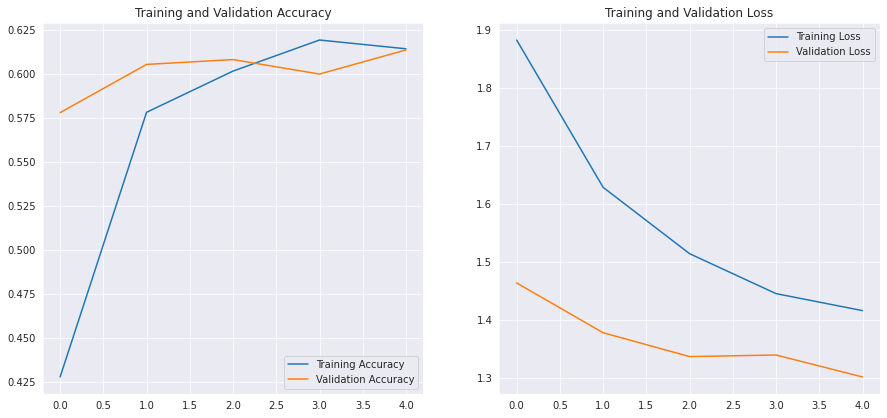

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
testImages = []
testDataLabels = []
test_images = []
f = open(TEST_FILENAMES, "r")
for r in f:
    r = r.split(",")
    img_path = r[0]
    annot_path = r[1][:-1]
    img_arr = cv2.imread(img_path)[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))

    class_num = getClassFromJson(annot_path)
    
    testDataNames.append(img_path)
    testDataLabels.append(class_num)
    test_images.append(resized_arr)
    
f.close()

<AxesSubplot:ylabel='count'>

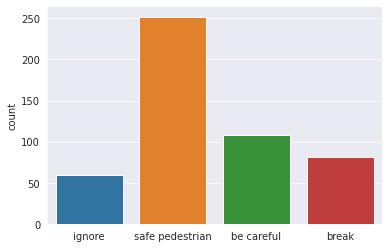

In [22]:
l = []
for i in testDataLabels:
    if i == 0:
        l.append("ignore")
    elif i == 1:
        l.append("safe pedestrian")
    elif i == 2:
        l.append("be careful")
    elif i == 3:
        l.append("break")
    else:
        print("should not happen")
sns.set_style('darkgrid')
sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])

In [34]:
#dataset_test = tf.data.Dataset.from_tensor_slices((testDataNames, testDataLabels))
#test_images = dataset_test.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)
test_images = np.array(test_images) / 255
test_images.reshape(-1, IMG_H, IMG_W, 1)

array([[[[0.12156863],
         [0.1372549 ],
         [0.11372549],
         ...,
         [0.27058824],
         [0.19607843],
         [0.2745098 ]],

        [[0.24705882],
         [0.20392157],
         [0.29411765],
         ...,
         [0.61176471],
         [0.50980392],
         [0.66666667]],

        [[0.76862745],
         [0.66666667],
         [0.50588235],
         ...,
         [0.49803922],
         [0.60784314],
         [0.59607843]],

        ...,

        [[0.09803922],
         [0.08627451],
         [0.06666667],
         ...,
         [0.42745098],
         [0.54117647],
         [0.52941176]],

        [[0.16470588],
         [0.23529412],
         [0.21176471],
         ...,
         [0.41568627],
         [0.36078431],
         [0.44705882]],

        [[0.42745098],
         [0.36470588],
         [0.44313725],
         ...,
         [0.09019608],
         [0.08235294],
         [0.07058824]]],


       [[[0.10196078],
         [0.09411765],
         [0.07

In [35]:
predictions = np.argmax(model.predict(test_images, batch_size=BATCH_SIZE), axis=-1)
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(testDataLabels, predictions, target_names = ['Ignore (Class 0)','safe pedestrian (Class 1)', 'Be careful (Class 2)', 'Break (Class 3)']))

                           precision    recall  f1-score   support

         Ignore (Class 0)       0.00      0.00      0.00        59
safe pedestrian (Class 1)       0.60      0.94      0.73       252
     Be careful (Class 2)       0.50      0.23      0.32       108
          Break (Class 3)       0.85      0.54      0.66        81

                 accuracy                           0.61       500
                macro avg       0.49      0.43      0.43       500
             weighted avg       0.55      0.61      0.54       500



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
confusion = tf.math.confusion_matrix(labels=testDataLabels, predictions=predictions, num_classes=4)
print(confusion)

tf.Tensor(
[[  0  59   0   0]
 [  0 238  11   3]
 [  0  78  25   5]
 [  0  23  14  44]], shape=(4, 4), dtype=int32)


In [25]:
saved_model_dir = 'saved_models'
tf.saved_model.save(model, saved_model_dir)

2022-11-13 21:21:52.709557: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [42]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

2022-11-13 21:43:42.837480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-11-13 21:43:42.837559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-11-13 21:43:42.837569: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-11-13 21:43:42.837888: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_models
2022-11-13 21:43:42.901300: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-11-13 21:43:42.901364: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models
2022-11-13 21:43:43.144890: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-13 21:43:45.138522: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: saved_models
2022-11-13 21:4

In [43]:
with open('mobilenet2_13_11_3pm.tflite', 'wb') as f:
  f.write(tflite_model)

class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, num_classes, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.num_classes = num_classes
    self.author = author

_MODEL_INFO = {
    "mobilenet2_13_11_3pm.tflite":
        ModelSpecificInfo(
            name="MobileNetV2",
            version="v1",
            image_width=512,
            image_height=512,
            image_min=0,
            image_max=255,
            mean=[127.5],
            std=[127.5],
            num_classes=4,
            author="TensorFlow")
}

In [44]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info, label_file_path):
    self.model_file = model_file
    self.model_info = model_info
    self.label_file_path = label_file_path
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Identify the most prominent object in the "
                              "image from a set of %d categories." %
                              self.model_info.num_classes)
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename(self.label_file_path)
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.load_associated_files([self.label_file_path])
    populator.populate()


In [45]:
import flatbuffers
model_file = "mobilenet2_13_11_3pm.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join(saved_model_dir, model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file), "../input/citypersondata-annot/labels.txt")
populator.populate()

In [46]:
# Validate the output model file by reading the metadata and produce
# a json file with the metadata under the export path
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join(saved_model_dir, os.path.splitext(model_basename)[0] + ".json")
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)

In [47]:
print("Finished populating metadata and associated file to the model:")
print(model_file)
print("The metadata json file has been saved to:")
print(export_json_file)
print("The associated file that has been been packed to the model is:")
print(displayer.get_packed_associated_file_list())

Finished populating metadata and associated file to the model:
mobilenet2_13_11_3pm.tflite
The metadata json file has been saved to:
saved_models/mobilenet2_13_11_3pm.json
The associated file that has been been packed to the model is:
['labels.txt']
